In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
full_df = pd.read_csv('Resources/dash_full_batter_data(1).csv')
batter_woba_df = pd.read_csv("Resources/full_woba_learning-handy.csv")
batter_slg_df = pd.read_csv("Resources/full_slg_learning-handy.csv")
batter_babip_df = pd.read_csv("Resources/full_babip_learning-handy.csv")
batter_wrc_df = pd.read_csv("Resources/full_wrc_learning-handy.csv")
batter_woba_df = batter_woba_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_slg_df = batter_slg_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_babip_df = batter_babip_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
batter_wrc_df = batter_wrc_df.drop(['z_scores_avg_woba', 'z_scores_avg_slg', 'z_scores_avg_babip', 'z_scores_avg_wrc+'], axis=1)
oneoff_babip_df = batter_babip_df.copy()
oneoff_babip_df = oneoff_babip_df[['BABIP+', 'BABIP', 'bat_side_L', 'bat_side_R', 'bat_side_S', 'zscore_difference_babip']]

In [3]:
def train_and_evaluate_logistic_regression(df, target_column, solver='lbfgs', max_iter=100):
    # Drop rows with missing values
    df.dropna(axis=1, inplace=True)
    
    # Convert the target column into binary classes (0 or 1)
    df[target_column] = df[target_column].apply(lambda x: 1 if x > 0 else 0)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    # Create the Logistic Regression model
    logreg_model = LogisticRegression(solver=solver, max_iter=max_iter)
    
    # Train the model
    logreg_model.fit(X_train_scaled, y_train_resampled)
    
    # Make predictions
    y_pred = logreg_model.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred)
    
    # Create the SHAP explainer with the trained model
    explainer = shap.Explainer(logreg_model, X_train_scaled)
    
    return {
        "accuracy": accuracy,
        "classification_report": class_report,
        "shap_values": explainer(X_test_scaled),
        "X_test_scaled": X_test_scaled,
        "X_train": X_train_resampled,
        "X_train_scaled": X_train_scaled
    }

In [4]:
target_column = 'zscore_difference_woba'
result_woba = train_and_evaluate_logistic_regression(batter_woba_df, target_column,  solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_woba['accuracy']:.2f}")
# print("Classification Report:")
# print(result_woba['classification_report'])

Accuracy: 0.65


In [5]:
# Call the function with your DataFrame and target column
result_slg = train_and_evaluate_logistic_regression(batter_slg_df, 'zscore_difference_slg', solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_slg['accuracy']:.2f}")
# print("Classification Report:")
# print(result_logreg['classification_report'])

Accuracy: 0.67


In [6]:
# Call the function with your DataFrame and target column
result_babip = train_and_evaluate_logistic_regression(batter_babip_df, 'zscore_difference_babip', solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_babip['accuracy']:.2f}")
# print("Classification Report:")
# print(result_logreg['classification_report'])

Accuracy: 0.62


In [7]:
result_babip = train_and_evaluate_logistic_regression(oneoff_babip_df, 'zscore_difference_babip', solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_babip['accuracy']:.2f}")

Accuracy: 0.69


In [8]:
# Call the function with your DataFrame and target column
result_wrc = train_and_evaluate_logistic_regression(batter_wrc_df, 'zscore_difference_wrc+', solver='lbfgs', max_iter=200)

# Access the results
print(f"Accuracy: {result_wrc['accuracy']:.2f}")
# print("Classification Report:")
# print(result_logreg['classification_report'])

Accuracy: 0.63


In [9]:
def train_and_evaluate_classifacation_model(df, target_column):
    # Drop rows with missing values
    df.dropna(axis=1, inplace=True)
    
    # Convert the target column into binary classes (0 or 1)
    df[target_column] = df[target_column].apply(lambda x: 1 if x > 0 else 0)
    
    # Split data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define cross-validation strategy
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Build the pipeline
    imb_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgbclassifier', xgb.XGBClassifier(
            max_depth=5,
            learning_rate=0.01,
            n_estimators=600,
            subsample=0.5,
            colsample_bytree=0.25,
            objective='binary:logistic',
            random_state=42
        ))
    ])
    
    # Cross-validate the pipeline
    cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='accuracy', cv=kf)
    
    # Train the pipeline on the training data
    imb_pipeline.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = imb_pipeline.predict(X_test_scaled)
    
    # Create the SHAP explainer
    final_estimator = imb_pipeline.named_steps['xgbclassifier']
    explainer = shap.Explainer(final_estimator, X_train_scaled)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_scaled, check_additivity=False)
    
    # Calculate evaluation metrics
    balanced_recall = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return {
        "cross_val_scores": cross_val_scores,
        "accuracy": accuracy,
        "balanced_recall": balanced_recall,
        "shap_values": shap_values,
        "X_test_scaled": X_test_scaled,
        "X_train": X_train,
        "X_train_scaled": X_train_scaled,
        "y_pred": y_pred,
        "y_test": y_test,
        "y_train": y_train,
        "X_test": X_test
    }

In [10]:
def create_predictions_dataframe(result_df, name_df):
    y_pred_train = result_df['y_train']
    y_pred_test = result_df['y_pred']
    y_train = result_df['y_train']
    y_test = result_df['y_test']
    
    indexes_train = result_df['X_train'].index
    indexes_test = result_df['X_test'].index
    
    names_train = name_df.loc[indexes_train, 'Name']
    predictions_with_names_train = list(zip(names_train, y_pred_train, y_train))
    
    names_test = name_df.loc[indexes_test, 'Name']
    predictions_with_names_test = list(zip(names_test, y_pred_test, y_test))
    
    predictions_df_train = pd.DataFrame(predictions_with_names_train, columns=['Name', 'Prediction', 'Actual'])
    predictions_df_test = pd.DataFrame(predictions_with_names_test, columns=['Name', 'Prediction', 'Actual'])
    
    # Add a column for correctness
    predictions_df_train['Correctness'] = np.where(predictions_df_train['Prediction'] == predictions_df_train['Actual'], 'Correct :)', 'Wrong :(')
    predictions_df_test['Correctness'] = np.where(predictions_df_test['Prediction'] == predictions_df_test['Actual'], 'Correct :)', 'Wrong :(')
    
    pred_actual_df = pd.concat([predictions_df_train, predictions_df_test], ignore_index=True)
    
    return pred_actual_df

In [11]:
result_woba = train_and_evaluate_classifacation_model(batter_woba_df, 'zscore_difference_woba')

# Print the results
print(f"Cross Value Scores: {result_woba ['cross_val_scores']}")
print(f"Accuracy: {result_woba ['accuracy']:.2f}")
print(f"Recall: {result_woba ['balanced_recall']:.2f}")

Cross Value Scores: [0.56097561 0.68292683 0.65853659 0.68292683 0.55      ]
Accuracy: 0.63
Recall: 0.64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


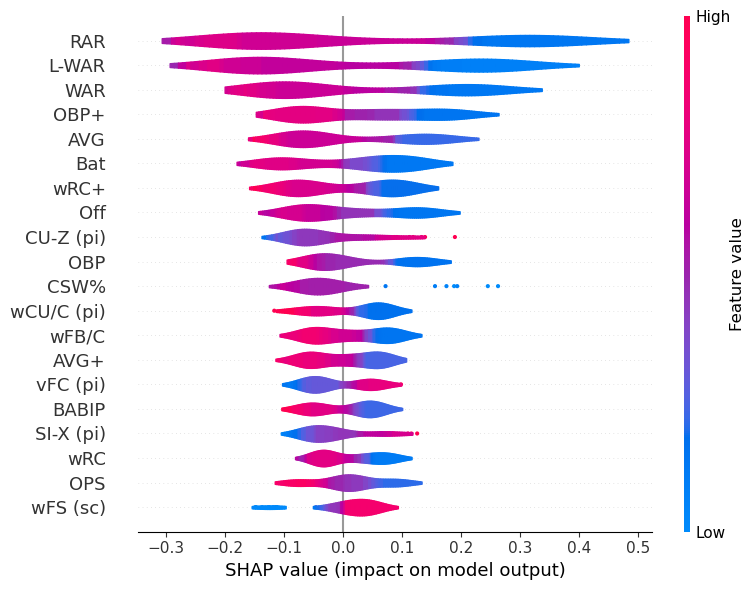

In [12]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_woba['shap_values'], result_woba['X_test_scaled'], plot_type='violin', feature_names=result_woba['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class_handy.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [13]:
pred_actual_woba = create_predictions_dataframe(result_woba, full_df)

new_columns = {
    "Prediction": "wOBA_Prediction",
    "Actual": "wOBA_Actual",
    "Correctness": "woba_Correctness"
}

pred_actual_woba= pred_actual_woba.rename(columns=new_columns)

In [14]:
result_slg = train_and_evaluate_classifacation_model(batter_slg_df, 'zscore_difference_slg')

# Print the results
print(f"Cross Value Scores: {result_slg ['cross_val_scores']}")
print(f"Accuracy: {result_slg ['accuracy']:.2f}")
print(f"Recall: {result_slg ['balanced_recall']:.2f}")

Cross Value Scores: [0.58536585 0.68292683 0.63414634 0.80487805 0.6       ]
Accuracy: 0.75
Recall: 0.75


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


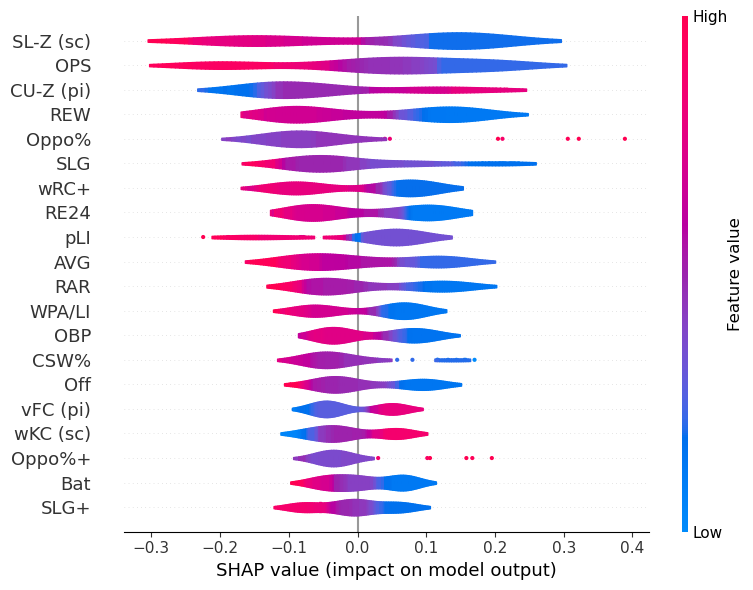

In [15]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_slg['shap_values'], result_slg['X_test_scaled'], plot_type='violin', feature_names=result_slg['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_slg_class_handy.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [16]:
pred_actual_slg = create_predictions_dataframe(result_slg, full_df)

new_columns = {
    "Prediction": "SLG_Prediction",
    "Actual": "SLG_Actual",
    "Correctness": "SLG_Correctness"
}

pred_actual_slg = pred_actual_slg.rename(columns=new_columns)

In [17]:
result_babip = train_and_evaluate_classifacation_model(batter_babip_df, 'zscore_difference_babip')

# Print the results
print(f"Cross Value Scores: {result_babip ['cross_val_scores']}")
print(f"Accuracy: {result_babip ['accuracy']:.2f}")
print(f"Recall: {result_babip ['balanced_recall']:.2f}")

Cross Value Scores: [0.63414634 0.56097561 0.58536585 0.7804878  0.65      ]
Accuracy: 0.75
Recall: 0.75


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


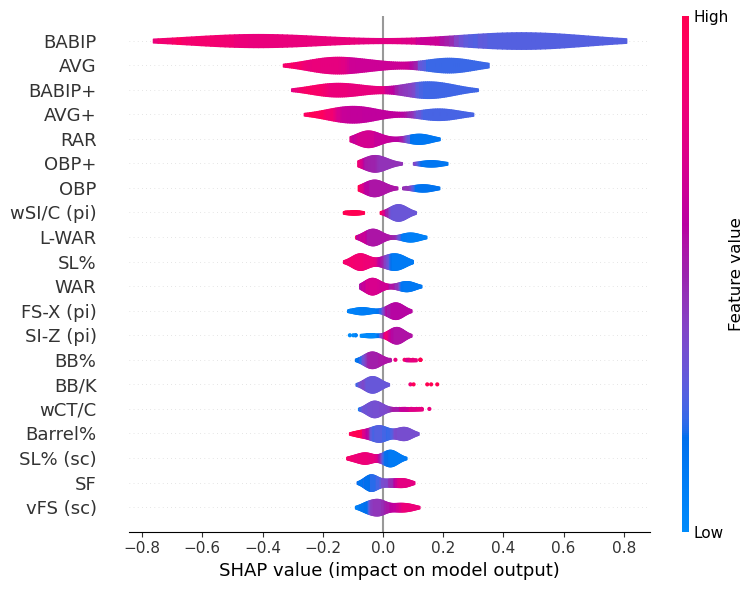

In [18]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_babip['shap_values'], result_babip['X_test_scaled'], plot_type='violin', feature_names=result_babip['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_babip_class_handy.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [19]:
pred_actual_babip = create_predictions_dataframe(result_babip, full_df)

new_columns = {
    "Prediction": "BABIP_Prediction",
    "Actual": "BABIP_Actual",
    "Correctness": "BABIP_Correctness"
}

pred_actual_babip = pred_actual_babip.rename(columns=new_columns)

In [20]:
result_babip_2 = train_and_evaluate_classifacation_model(oneoff_babip_df, 'zscore_difference_babip')

print(f"Cross Value Scores: {result_babip_2 ['cross_val_scores']}")
print(f"Accuracy: {result_babip_2 ['accuracy']:.2f}")
print(f"Recall: {result_babip_2 ['balanced_recall']:.2f}")

Cross Value Scores: [0.68292683 0.63414634 0.68292683 0.63414634 0.625     ]
Accuracy: 0.73
Recall: 0.73


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


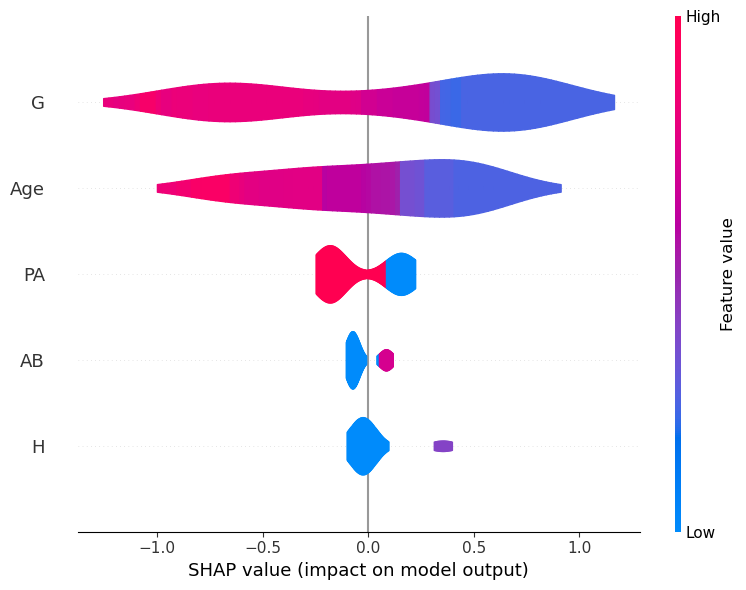

In [21]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_babip_2['shap_values'], result_babip_2['X_test_scaled'], plot_type='violin', feature_names=result_babip['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_babip_class_few_features.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [22]:
result_wrc = train_and_evaluate_classifacation_model(batter_wrc_df, 'zscore_difference_wrc+')

# Print the results
print(f"Cross Value Scores: {result_wrc ['cross_val_scores']}")
print(f"Accuracy: {result_wrc ['accuracy']:.2f}")
print(f"Recall: {result_wrc ['balanced_recall']:.2f}")

Cross Value Scores: [0.56097561 0.68292683 0.6097561  0.80487805 0.525     ]
Accuracy: 0.67
Recall: 0.67


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


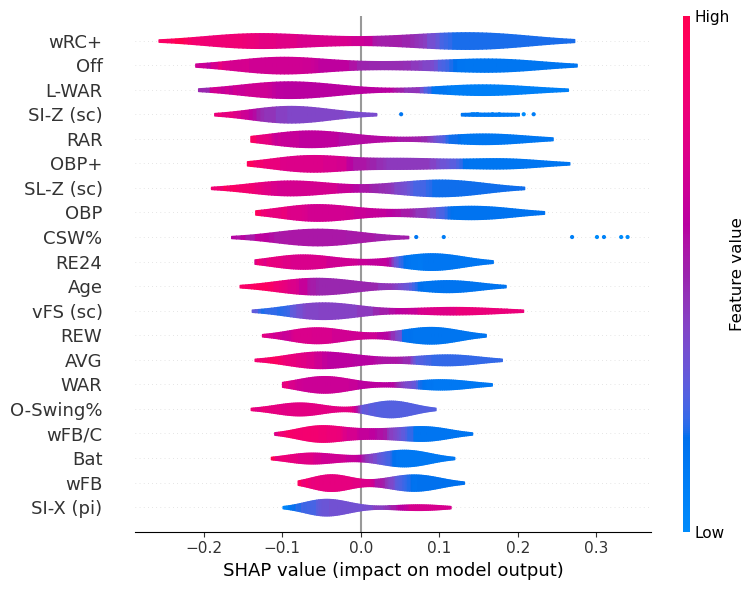

In [23]:
# Generate SHAP summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(result_wrc['shap_values'], result_wrc['X_test_scaled'], plot_type='violin', feature_names=result_wrc['X_train'].columns, show=False)
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_wrc_class_handy.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [24]:
pred_actual_wrc = create_predictions_dataframe(result_wrc, full_df)

new_columns = {
    "Prediction": "wRC+_Prediction",
    "Actual": "wRC+_Actual",
    "Correctness": "wRC+_Correctness"
}

pred_actual_wrc = pred_actual_wrc.rename(columns=new_columns)


In [25]:
# Merge the DataFrames on the "Name" column
merged_df = pd.merge(pred_actual_woba, pred_actual_slg, on="Name")
merged_df = pd.merge(merged_df, pred_actual_babip, on="Name")
merged_df = pd.merge(merged_df, pred_actual_wrc, on="Name")

verdict_df = merged_df.drop(["wOBA_Prediction", "wOBA_Actual", "SLG_Prediction", "SLG_Actual",
                             "BABIP_Prediction", "BABIP_Actual", "wRC+_Prediction", "wRC+_Actual"], axis=1)

verdict_df.head()

,Name,woba_Correctness,SLG_Correctness,BABIP_Correctness,wRC+_Correctness
0,Andrew Benintendi,Correct :),Correct :),Correct :),Correct :)
1,Carlos Correa,Correct :),Correct :),Correct :),Correct :)
2,Max Kepler,Correct :),Correct :),Correct :),Correct :)
3,Jeremy Pena,Correct :),Correct :),Correct :),Correct :)
4,Hunter Renfroe,Correct :),Correct :),Correct :),Correct :)


In [26]:
verdict_df.to_csv('Resources/verdict-handy.csv', index=False)